# Exploring Downsampling Methods for Classification

When creating a model that classifies a data point, downsampling plays an important role when preparing a training set. In particular, downsampling addresses two major issues:

1. Data may be imbalanced such that one class has significantly more / less representation than other samples.
2. The number of data points is too much; this may become an issue when working with limited computing capabilities.

To address these two issues, I list a couple of downsampling techniques and explore their properties.

## Test Data

Here is some test data to work with as we test out our downsampling methods. For this test data, we will create 2 lines on a cartesian plane. Those two lines split the plane into 4 sections and each of those four sections will be assigned a class.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
line1 = lambda x: 2 * x + 1

line2 = lambda x: 0.5 * x - .5


In [3]:
num_points = 5000

# Points are generated on a square grid. Each axis starts and ends at
# min and max, respectively.
min_val = -4
max_val = 4

data = np.random.rand(2, num_points) * (max_val - min_val) + min_val


In [4]:
def classify_points(X):
    """
    Classifies a point (or set of points) into 1 of 4 classes.
    This will return a numpy array of integers between 1 and 4
    representing the classes for each point.
    """
    
    eval_line1 = line1(X[0, :])
    # Mask indicating if a point is above line 1.
    line1_mask = eval_line1 >= X[1, :]
    
    eval_line2 = line2(X[0, :])
    # Mask indicating if a point is above line 2.
    line2_mask = eval_line2 >= X[1, :]
    
    m = X.shape[1] # number of sample points.
    classes = np.zeros(m)
    
    # Record the class of each point.
    classes = classes + (~line1_mask & ~line2_mask) * 1
    classes = classes + (~line1_mask &  line2_mask) * 2
    classes = classes + ( line1_mask & ~line2_mask) * 3
    classes = classes + ( line1_mask &  line2_mask) * 4
    
    return classes
    

In [5]:
labels = classify_points(data)

In [6]:
def display_classes(X, Y):
    data_class1 = X[:, Y == 1]
    data_class2 = X[:, Y == 2]
    data_class3 = X[:, Y == 3]
    data_class4 = X[:, Y == 4]

    plt.scatter(data_class1[0, :], data_class1[1, :], c='r')
    plt.scatter(data_class2[0, :], data_class2[1, :], c='g')
    plt.scatter(data_class3[0, :], data_class3[1, :], c='b')
    plt.scatter(data_class4[0, :], data_class4[1, :], c='c')
    
    plt.legend([f'Class {i+1}' for i in range(4)])
    plt.show()


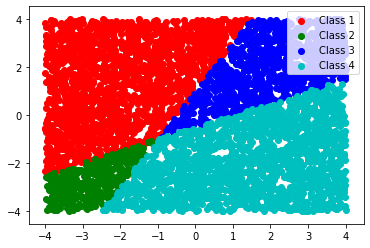

In [7]:
display_classes(data, labels)

We can see how the point classification boundaries have resulted in an imbalance in examples for each classification. There are much fewer points that fall under class 2 (green) than class 4 (cyan). This imbalance in data can skew the results of our learning algorithms if fed directly into our data. This is where downsampling is valuable as a pre-processing step.

## Formalizing our Problem

Let there be $n$ classes of data points. When pulling from the population, the probability of the pulling a point that belongs to class $i$ is $c_i$. Note that $\sum_{i=1}^n c_i = 1$.

From this population, we generate a sample $X$ of $m$ points. We do not know the $c_i$ probabilities of the population, but using our sample, we take an unbiased estimate of those probabilities: $\hat{c}_i = \frac {1} {m} \sum_{j=1}^m \mathbb{1} (x_j \in C_i)$. We assume that our sample size is large enough (and variance is small enough) that these point estimates is reasonably accurate. Note that our estimates have the desired property: $\sum_{i=1}^n \hat{c}_i = 1$.

In [8]:
def calculate_c_hats(Y):
    """
    Calculate and return the c_hat values for every class in
    the dataset.
    """
    m = len(Y)

    c1_hat = float(np.sum(Y == 1)) / m
    c2_hat = float(np.sum(Y == 2)) / m
    c3_hat = float(np.sum(Y == 3)) / m
    c4_hat = float(np.sum(Y == 4)) / m
    
    
    return c1_hat, c2_hat, c3_hat, c4_hat


In [9]:
c1_hat, c2_hat, c3_hat, c4_hat = calculate_c_hats(labels)

print(f'c1_hat:\t{c1_hat*100:.02f}%')
print(f'c2_hat:\t{c2_hat*100:.02f}%')
print(f'c3_hat:\t{c3_hat*100:.02f}%')
print(f'c4_hat:\t{c4_hat*100:.02f}%')


c1_hat:	36.84%
c2_hat:	7.60%
c3_hat:	19.54%
c4_hat:	36.02%


## Method 1: Equal Representation Downsampling

We want to filter out some of these data points, but we want to do so such that we filter out more points that belong to classes that have greater representation. On simple thought is that after our downsampling is complete, we would like all of our classes to have *approximately* equal representation.

Let $\hat{c}*$ be the smallest probability of all our classes: $\hat{c}* = \mbox{min}_i (\hat{c}_i)$. This means that our smallest class has $m \cdot \hat{c}*$ data points and we would like of our classes to have approximately that number of data points.

To accomplish this, we use the following algorithm:
    
- For each point in the sample:
    - The point belongs to class $C_i$
    - Keep the point in the dataset with probability $\frac {\hat{c}*} {\hat{c}_i}$
    - Otherwise, filter out the point.

Let $x^i_j$ be the $jth$ point in our sample that is a member of class $i$, and let $n_i$ be the number of points within our sample that belong to class $i$. Let $p_i = \frac {\hat{c}*} {\hat{c}_i}$ be the *keep probability* that we keep a point of class $i$ after downsampling. Note that for each class, we have a binomial distribution $f(k; i)$ which measures the probability of there being $k$ samples remaining of class $i$ after applying the downsampling algorithm.

The expected value of this binomial distribution for class $i$ is $m \hat{c}_i \cdot p_i = m \hat{c}_i \cdot \frac {\hat{c}*} {\hat{c}_i} = m \cdot \hat{c}_i$, which is the number of samples in our smallest class.

## Method 2: Exponential-Adjusted Downsampling

Equal representation downsampling may be too agressive an approach. If there is a large imbalance between our classes, equal representation downsampling algorithm may end up throwing away too many examples.

A softer approach is exponential-adjusted downsampling. The overall idea is the same, except we introduce a paramter $\lambda$ to adjust the aggresiveness of downsampling. This parameter is used to configure our keep probability $p_i$ as follows:

$$p_i(\lambda) = \left( \frac {\hat{c}*} {c_i} \right) ^ {\frac {1} {\lambda}}$$

When $\lambda$ is 1, $p_i$ becomes identical to the keep probability used for equal representation downsampling. However, as $\lambda$ approaches infinity, the keep probability approaches 1, meaning we do not filter any points in our data.

In [10]:
def exp_adj_downsampling(X, Y, lambd):
    """
    Downsample X and Y values using the exponentially adjusted
    downsampling algorithm. Returns a new X, Y pair with the new
    downsampled values.
    """
    m = Y.shape[0]

    c1_mask = Y == 1
    c2_mask = Y == 2
    c3_mask = Y == 3
    c4_mask = Y == 4

    c1_hat, c2_hat, c3_hat, c4_hat = calculate_c_hats(Y)
    cstar_hat = min(c1_hat, c2_hat, c3_hat, c4_hat)

    keep_prob = np.zeros(m)
    keep_prob = keep_prob + (c1_mask * (cstar_hat / c1_hat) ** (1. / lambd))
    keep_prob = keep_prob + (c2_mask * (cstar_hat / c2_hat) ** (1. / lambd))
    keep_prob = keep_prob + (c3_mask * (cstar_hat / c3_hat) ** (1. / lambd))
    keep_prob = keep_prob + (c4_mask * (cstar_hat / c4_hat) ** (1. / lambd))

    keep_val = np.random.rand(m)
    
    keep_mask = keep_val < keep_prob

    X = X[:, keep_mask]
    Y = Y[keep_mask]

    return X, Y


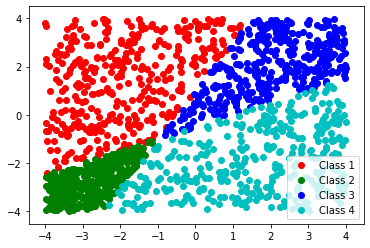

In [11]:
# What our sample looks like when we equalize all classes:

X, Y = exp_adj_downsampling(data, labels, lambd=1)

display_classes(X, Y)


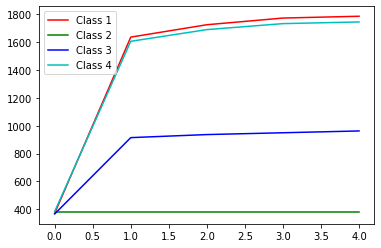

In [12]:
lambdas = np.linspace(start=1, stop=50, num=5)

m = len(labels)
class_portions = np.zeros((4, len(lambdas)))

for i, lambd in enumerate(lambdas):
    X, Y = exp_adj_downsampling(data, labels, lambd=lambd)
    c1_hat, c2_hat, c3_hat, c4_hat = calculate_c_hats(Y)

    class_portions[:, i] = np.array([c1_hat, c2_hat, c3_hat, c4_hat]) * len(Y)
    

plt.plot(class_portions[0, :], c='r')
plt.plot(class_portions[1, :], c='g')
plt.plot(class_portions[2, :], c='b')
plt.plot(class_portions[3, :], c='c')

plt.legend([f'Class {i+1}' for i in range(4)])
plt.show()
    

Using the binomial distribution, we can calculate the expected number of samples remaining for a particular class as a function of $lambda$

$$\mathbb{E}(i; \lambda) = m \hat{c}_i \cdot p_i(\lambda) = m \cdot (\hat{c}_i)^{\frac{\lambda - 1}{\lambda}} \cdot (\hat{c}*)^{\frac{1}{\lambda}} $$

We can see that a $\lambda$ value of 1 will result in an expected number of $m \cdot \hat{c}*$ samples for all classes, while as $\lambda$ approaches infinity, the number of samples in each class $i$ approaches $m \cdot \hat{c}_i$, which is the number of elements in the class before sampling.

Some caveats with the exponential-adjusted downsampling method:

1. It is difficult to set a global downsampling parameter. The $\lambda$ parameter that is passed into downsampling is opaque and it is not immediately clear how the $\lambda$ value will affect downsampling across the entire dataset. For example, let's say I want to reduce the total sample size down to about 80% of the original sample size. The relationship between the $\lambda$ and the global sampling rate, $g$ is as follows:

$$ g = \sum_{i=1}^{n} \hat{c}_i \cdot \left( \frac {\hat{c}*} {\hat{c}_i} \right) ^ {\frac{1}{\lambda}} $$

There is no known analytical solution to solve for $\lambda$ in terms of g, so deriving a global sampling rate from $\lambda$ will require some numerical methods.

2. The $\lambda$ parameter behaves well for values $\ge 1$. For values between 0 and 1, $\lambda$ will begin downsampling classes such that they have fewer than $\hat{c}*$ elements, but will not downsample the minimal class, which is strange and likely undesired behavior. Better behavior would ideally be that all classes are porportionally downsampled in some way. $\lambda \lt 0$ has no real meaning.

## Method 3: Linearly-Adjusted Downsampling

To address the issue of deriving a global sampling rate, we can simplify our $p_i$ keep probability into the following:

$$p_i = (1 - \lambda) \frac {\hat{c}*} {\hat{c}_i} + \lambda (1) $$

When $\lambda$ is 0, we downsample such that all classes have equal representation and when $\lambda$ is 1, we perform no downsampling on any class.

Making this change to the keep probability gives us a formula that we can use to derive the global sampling rate:

$$ g = \sum_{i=1}^{n} \hat{c}_i \left( (1 - \lambda) \frac {\hat{c}*} {\hat{c}_i} + \lambda (1) \right) = n\hat{c}^{*} (1 - \lambda) + \lambda $$

$$\lambda = \frac {g - n \hat{c}*} {1 - n \hat{c}*}$$

So given a desired global sampling rate, we can calculate a corresponding $\lambda$.

In [13]:
def linear_adj_downsampling(X, Y, lambd):
    """
    Downsample X and Y values using the exponentially adjusted
    downsampling algorithm. Returns a new X, Y pair with the new
    downsampled values.
    """
    m = Y.shape[0]

    c1_mask = Y == 1
    c2_mask = Y == 2
    c3_mask = Y == 3
    c4_mask = Y == 4

    c1_hat, c2_hat, c3_hat, c4_hat = calculate_c_hats(Y)
    cstar_hat = min(c1_hat, c2_hat, c3_hat, c4_hat)

    keep_prob = np.zeros(m)
    keep_prob = keep_prob + (c1_mask * ((1 - lambd) * cstar_hat / c1_hat + lambd))
    keep_prob = keep_prob + (c2_mask * ((1 - lambd) * cstar_hat / c2_hat + lambd))
    keep_prob = keep_prob + (c3_mask * ((1 - lambd) * cstar_hat / c3_hat + lambd))
    keep_prob = keep_prob + (c4_mask * ((1 - lambd) * cstar_hat / c4_hat + lambd))

    keep_val = np.random.rand(m)
    
    keep_mask = keep_val < keep_prob

    X = X[:, keep_mask]
    Y = Y[keep_mask]

    return X, Y


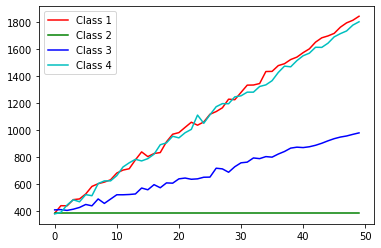

In [14]:
lambdas = np.linspace(start=0, stop=1, num=50)

m = len(labels)
class_portions = np.zeros((4, len(lambdas)))

for i, lambd in enumerate(lambdas):
    X, Y = linear_adj_downsampling(data, labels, lambd=lambd)
    c1_hat, c2_hat, c3_hat, c4_hat = calculate_c_hats(Y)

    class_portions[:, i] = np.array([c1_hat, c2_hat, c3_hat, c4_hat]) * len(Y)
    

plt.plot(class_portions[0, :], c='r')
plt.plot(class_portions[1, :], c='g')
plt.plot(class_portions[2, :], c='b')
plt.plot(class_portions[3, :], c='c')

plt.legend([f'Class {i+1}' for i in range(4)])
plt.show()


One caveat with the linear method is that we cannot set the sampling rate to be less than $n \cdot \hat{c}^*$ (which is equal to the number of classes $n$ times the smallest $\hat{c}$ value. A global sampling rate below this value has no probablistic meaning and fails to be calculated correctly.